In [1]:
import tensorflow as tf
import keras
from keras.layers import Softmax,Input,TimeDistributed,Dense,Average,GlobalAveragePooling1D,Concatenate,Lambda,RepeatVector
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import plot_model
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pylab as pl
from IPython import display
from IPython.core.display import HTML
from IPython.core.display import display as html_width
import tensorflow_probability as tfp
from scipy.interpolate import UnivariateSpline

html_width(HTML("<style>.container { width:90% !important; }</style>"))

/home/tuluhan/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tuluhan/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tuluhan/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tuluhan/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:5

#### The LfD part of the code is taken from https://github.com/rssCNMP/CNMP

## Creating dataset
* Here 1 false demonstration is collected for the task


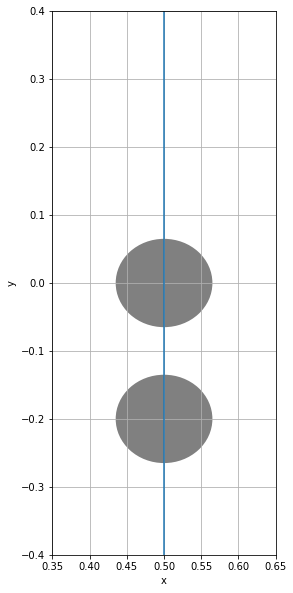

[[[ 0.5        -0.4       ]
  [ 0.5        -0.3959799 ]
  [ 0.5        -0.3919598 ]
  [ 0.5        -0.3879397 ]
  [ 0.5        -0.3839196 ]
  [ 0.5        -0.3798995 ]
  [ 0.5        -0.3758794 ]
  [ 0.5        -0.3718593 ]
  [ 0.5        -0.3678392 ]
  [ 0.5        -0.3638191 ]
  [ 0.5        -0.35979899]
  [ 0.5        -0.35577889]
  [ 0.5        -0.35175879]
  [ 0.5        -0.34773869]
  [ 0.5        -0.34371859]
  [ 0.5        -0.33969849]
  [ 0.5        -0.33567839]
  [ 0.5        -0.33165829]
  [ 0.5        -0.32763819]
  [ 0.5        -0.32361809]
  [ 0.5        -0.31959799]
  [ 0.5        -0.31557789]
  [ 0.5        -0.31155779]
  [ 0.5        -0.30753769]
  [ 0.5        -0.30351759]
  [ 0.5        -0.29949749]
  [ 0.5        -0.29547739]
  [ 0.5        -0.29145729]
  [ 0.5        -0.28743719]
  [ 0.5        -0.28341709]
  [ 0.5        -0.27939698]
  [ 0.5        -0.27537688]
  [ 0.5        -0.27135678]
  [ 0.5        -0.26733668]
  [ 0.5        -0.26331658]
  [ 0.5        -0.25

In [2]:
time_N = 200
Y=np.zeros((1,time_N,2))
Y_old=np.zeros((1,time_N,2))
times = np.linspace(0,1,time_N)
traj_x1 = np.linspace(0.5,0.5,time_N)
traj_y1 = np.linspace(-0.4,0.4,time_N)
Y[0,:,0] = traj_x1
Y[0,:,1] = traj_y1
fig = plt.figure(figsize=(4,10))
ax = fig.add_subplot(111)
ax.set_xlim((0.35,0.65))
ax.set_ylim((-0.4,0.4))
ax.grid(True)
c_patch1 = plt.Circle((0.5, -0.2), 0.065, fc='gray')
c_patch2 = plt.Circle((0.5, 0), 0.065, fc='gray')
ax.add_patch(c_patch1)
ax.add_patch(c_patch2)
ax.set_ylabel("y")
ax.set_xlabel("x")
plt.plot(Y[0,:,0],Y[0,:,1])
plt.show()
print(Y)
np.save("initial_array",Y)

In [3]:
def square_diff(arr1,arr2):
    diff = np.sqrt(np.square(arr1[0]-arr2[0])+np.square(arr1[1]-arr2[1]))
    return diff

In [4]:
def plot_func(predicted_Y):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(121)
    
    ax.grid(True)
    c_patch1 = plt.Circle((0.5, -0.2), 0.065, fc='gray')
    c_patch2 = plt.Circle((0.5, 0), 0.065, fc='gray')
    ax.add_patch(c_patch1)
    ax.add_patch(c_patch2)
    ax.set_ylabel("y")
    ax.set_xlabel("x")
    ax.plot(predicted_Y[0,:,0],predicted_Y[0,:,1],'black',linewidth=7.0)
    for i in range(len(Y)):
        ax.plot(Y[i,:,0],Y[i,:,1])
    ax2 = fig.add_subplot(122)
    for i in range(len(Y)):
        if i == 0:
            ax2.plot(times,Y[i,:,0],'blue', label='x')
            ax2.plot(times,Y[i,:,1],'green',label='y')
        else:
            ax2.plot(times,Y[i,:,0],'blue')
            ax2.plot(times,Y[i,:,1],'green')
    ax2.set_xlabel("time")
    ax2.grid(True)
    ax2.legend()
    plt.show()

In [5]:
def plot_func2(Y):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(121)
    
    ax.grid(True)
    c_patch1 = plt.Circle((0.5, -0.2), 0.065, fc='gray')
    c_patch2 = plt.Circle((0.5, 0), 0.065, fc='gray')
    ax.add_patch(c_patch1)
    ax.add_patch(c_patch2)
    ax.set_ylabel("y")
    ax.set_xlabel("x")
    for i in range(len(Y)):
        ax.plot(Y[i,:,0],Y[i,:,1])
    ax2 = fig.add_subplot(122)
    for i in range(len(Y)):
        if i == 0:
            ax2.plot(times,Y[i,:,0],'blue', label='x')
            ax2.plot(times,Y[i,:,1],'green',label='y')
        else:
            ax2.plot(times,Y[i,:,0],'blue')
            ax2.plot(times,Y[i,:,1],'green')
    ax2.set_xlabel("time")
    ax2.grid(True)
    ax2.legend()
    plt.savefig('experiment_3_soln.png',bbox_inches='tight')
    plt.show()

In [6]:
def reward_func(Y):
    length = 0
    reward = 0
    counter = 0
    bottle1=np.array([0.5,-0.2])
    bottle2=np.array([0.5,0.0])
    
    #length of trajectory
    for i in range(199):
        length -= square_diff(Y[0,i,:],Y[0,i+1,:])
        
    #crushing first bottle
    for i in range(199):
        if (0.065 > square_diff(bottle1,Y[0,i,:])):
            reward -=2
            break
            
    #crushing second bottle
    for i in range(199):
        if (0.065 > square_diff(bottle2,Y[0,i,:])):
            reward -=2
            break
    #crossing between bottles
    counter = 0
    first_sign = 0
    for i in range(199):
        if Y[0,i,1]>-0.135 and Y[0,i,1]<-0.065 and Y[0,i,0] > 0.42 and Y[0,i,0]<0.58:
            if first_sign == 0:
                if Y[0,i,0] < 0.5:
                    first_sign = -1
                elif Y[0,i,0] > 0.5:
                    first_sign = 1
            elif first_sign == 1 and Y[0,i,0] < 0.5:
                first_sign = -1
                counter = counter +1
            elif first_sign == -1 and Y[0,i,0] > 0.5:
                first_sign = 1
                counter = counter +1
                
    mod = counter%2
    if mod == 1:
        reward += 4
    return reward+0.15*length   

-4.121248338786279


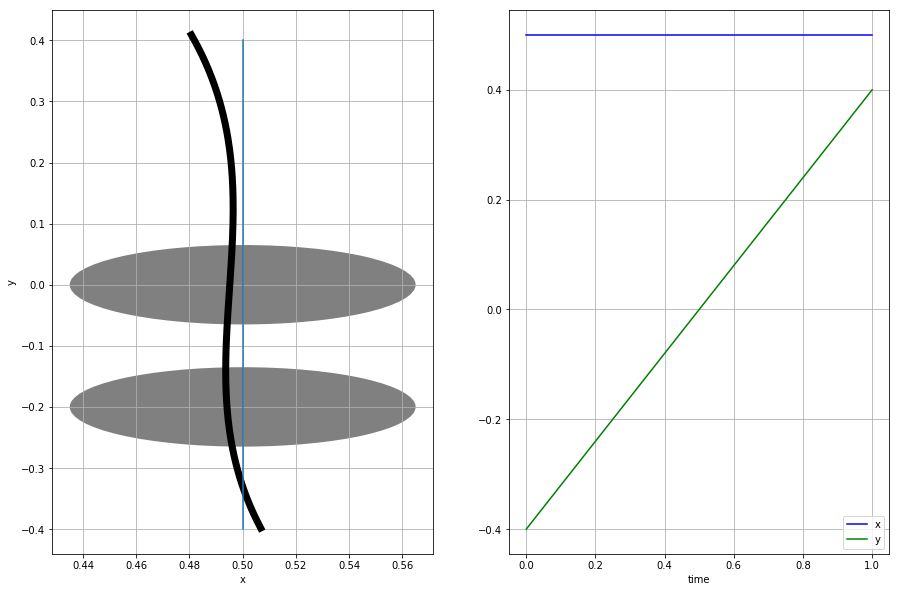

In [7]:
for i in range(2):
    samples = np.random.normal(0, 0.05, size=200)

    old_indices = np.arange(0,len(samples))
    new_length = 200
    new_indices = np.linspace(0,len(samples)-1,new_length)

    spl = UnivariateSpline(old_indices,samples,k=3,s=0.8)

    task_exploration=spl(new_indices)
    Y_old[0,:,i] = Y[0,:,i]+ task_exploration
print(reward_func(Y_old))
plot_func(Y_old)

## Training and validation trajectories are plotted 

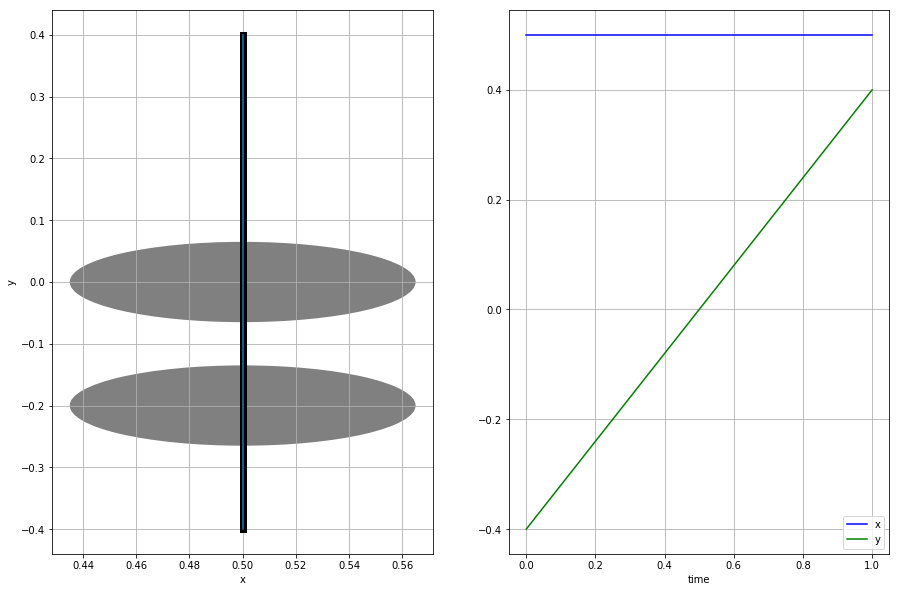

In [8]:
time_N = 200
times = np.linspace(0,1,time_N)
data_size=1
n_max=5
for p in range(data_size):
        plot_func(Y)
plt.show()        


* <b>obs_max</b>: Hyperparameter that decides to the maximum number of observations RCNMP uses. In this experiment, it is set to 5
    
* <b>d_N</b>: Number of demonstrations

* <b>d_x</b>: X vector feature dim (NOTE THAT: external parameters are inside of the X vector, concatenated to time value. )

* <b>d_y</b>: Y vector feature dim

* <b>time_len</b>: length of the demonstrations, if all demonstrations does not have same length, use array and edit methods using time_len, or preprocess your data to interpolate into same time length (check numpy.interp)

* <b>X</b>: shape=(d_N,time_len,d_x) --- time (and external parameter) values for each timestep for ith demonstration. d_x = 1+d_external_parameters

* <b>obs_mlp_layers</b>: Hidden neuron numbers of the dense layers inside of the Observation multi layer perceptron. Layer numbers can adapt to the list size. Last layer is always Linear, others are ReLU activated.

* <b>decoder_layers</b>: Hidden neuron numbers of the dense layers inside of the Decoder multi layer perceptron. Layer numbers can adapt to the list size. Last layer size is always 2*d_y and activation is Linear, others are ReLU activated.

In [9]:
X = np.zeros((data_size,time_N,2))
initial_reward=reward_func(Y)
print(initial_reward)
for i in range(data_size):
    for j in range(time_N):
        X[i,j,0]=times[j]
        X[i,j,1]=initial_reward

test_X = X
test_Y = Y
        
obs_max = 5 
d_N = X.shape[0] 
d_x , d_y = (X.shape[-1] , Y.shape[-1])
time_len = X.shape[1] 
obs_mlp_layers = [128,128,64,32,16]
decoder_layers = [128,128,64,32,d_y]

print ('d_N=', d_N)
print ('obs_max=', obs_max)
print ('X',X.shape,', Y',Y.shape)
print ('d_x=',d_x)
print ('d_y=',d_y)
print ('time_len=', time_len )
print(initial_reward)

-4.12
d_N= 1
obs_max= 5
X (1, 200, 2) , Y (1, 200, 2)
d_x= 2
d_y= 2
time_len= 200
-4.12


In [10]:
def initialization():
    global Y,test_Y,X,test_X
    time_N = 200
    Y=np.zeros((1,time_N,2))
    Y_old=np.zeros((1,time_N,2))
    times = np.linspace(0,1,time_N)
    traj_x1 = np.linspace(0.5,0.5,time_N)
    traj_y1 = np.linspace(-0.4,0.4,time_N)
    Y[0,:,0] = traj_x1
    Y[0,:,1] = traj_y1
    times = np.linspace(0,1,time_N)
    data_size=1
    n_max=5
    X = np.zeros((data_size,time_N,2))
    initial_reward=reward_func(Y)
    print(initial_reward)
    for i in range(data_size):
        for j in range(time_N):
            X[i,j,0]=times[j]
            X[i,j,1]=initial_reward

    test_X = X
    test_Y = Y

In [11]:
def get_train_sample():
    n = np.random.randint(0,obs_max)+1
    d = np.random.randint(0, d_N)
    observation = np.zeros((1,n,d_x+d_y)) 
    target_X = np.zeros((1,1,d_x))
    target_Y = np.zeros((1,1,d_y))
    perm = np.random.permutation(time_len)
    observation[0,:n,:d_x] = X[d,perm[:n]]
    observation[0,:n,d_x:d_x+d_y] = Y[d,perm[:n]]
    target_X[0,0] = X[d,perm[n]]
    target_Y[0,0,:d_y] = Y[d,perm[n]]
    return [observation,target_X], target_Y

In [12]:
def predict_model(observation, target_X, plot = True):
    predicted_Y = np.zeros((time_len,d_y))
    predicted_std = np.zeros((time_len,d_y))
    prediction = model.predict([observation,target_X])[0][0]
    predicted_Y = np.reshape(prediction[:,:d_y],(1,time_N,d_y))
    
    #predicted_std = np.log(1+np.exp(prediction[:,d_y:]))
    if plot: # We highly recommend that you customize your own plot function, but you can use this function as default
        plot_func(predicted_Y)
    return predicted_Y, predicted_std

### Z Sampling():
* Samples z according to given mean and log variance

In [13]:
def z_sampling(args):
    z_m, z_l_v = args
    batch = K.shape(z_m)[0]
    dim = K.int_shape(z_m)[-1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_m + K.exp(0.5 * z_l_v) * epsilon

def s_sampling(args):
    d_m, d_l_v = args
    batch = K.shape(d_m)[0]
    dim = K.int_shape(d_m)[-1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    epsilon = K.repeat(epsilon,K.shape(d_m)[1])
    return d_m + K.exp(0.5 * d_l_v) * epsilon

In [14]:
def custom_loss(y_true, y_predicted):
    mean, log_sigma = tf.split(y_predicted, 2, axis=-1)
    y_true_value, temp =tf.split(y_true,2,axis=-1)
    sigma = tf.nn.softplus(log_sigma)
    dist = tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=sigma)
    loss = -tf.reduce_mean(dist.log_prob(y_true_value))
    return loss

In [15]:
def MLP(input_dim, layers, name="mlp", parallel_inputs=False):
    input_layer = Input(shape=(None, input_dim),name=name+'_input')
    for i in range(len(layers)-1):
        hidden = TimeDistributed(Dense(layers[i], activation='relu'), name=name+'_'+str(i))(input_layer if i == 0 else hidden) if parallel_inputs else Dense(layers[i], activation='relu', name=name+'_'+str(i))(input_layer if i == 0 else hidden)
    hidden = TimeDistributed(Dense(layers[-1]), name=name+'_output')(hidden) if parallel_inputs else Dense(layers[-1], name=name+'_output')(hidden)
    return Model(input_layer, hidden, name=name)

## LfD Model

In [16]:
observation_layer = Input(shape=(None,d_x+d_y), name="observation") # (x_o,y_o) tuples
target_X_layer = Input(shape=(None,d_x), name="target") # x_q
print(np.shape(observation_layer))
print(np.shape(target_X_layer))

ObsMLP = MLP(d_x+d_y, obs_mlp_layers, name='obs_mlp', parallel_inputs=True) # Network E
obs_representations = ObsMLP(observation_layer) # r_i
general_representation1 = GlobalAveragePooling1D()(obs_representations) # r

z_mean = Dense(16,name='z_mean')(general_representation1) # Z mean
z_log_var = Dense(16,name='z_log_var')(general_representation1) # Z log var
z_log_var2 = Lambda(lambda x: 0.001+tf.nn.softplus(x))(z_log_var)
z = Lambda(z_sampling, output_shape=(16,), name='z')([z_mean, z_log_var]) # Z Sample
z = Lambda(lambda x: tf.keras.backend.repeat(x[0],tf.shape(x[1])[1]), name='Repeat_z')([z,target_X_layer]) # z in batch form (same)

merged_layer = Concatenate(axis=2, name='merged')([z,target_X_layer]) # (r,x_q) tuple
Decoder = MLP(d_x+obs_mlp_layers[-1], decoder_layers, name = 'decoder_mlp', parallel_inputs=False) # Network Q
output = Decoder(merged_layer) # (mean_q, std_q)

vae_loss = 0.01 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1. - z_log_var, axis=1)

model = Model([observation_layer, target_X_layer],[output,z_log_var])
model_z = Model([observation_layer],z_mean)
model_z_var = Model([observation_layer],z_log_var)
model_z_var2 = Model([observation_layer],z_log_var2)
model.add_loss(vae_loss)
model.compile(optimizer = Adam(lr = 1e-4), loss={'decoder_mlp': 'mse'})
model.summary()

rep_model = Model([observation_layer],general_representation1)

#plot_model(model)

W1119 17:36:53.700918 140351899981568 deprecation_wrapper.py:119] From /home/tuluhan/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1119 17:36:53.716050 140351899981568 deprecation_wrapper.py:119] From /home/tuluhan/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1119 17:36:53.716896 140351899981568 deprecation_wrapper.py:119] From /home/tuluhan/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



(?, ?, 4)
(?, ?, 2)


W1119 17:36:54.139747 140351899981568 deprecation_wrapper.py:119] From /home/tuluhan/.local/lib/python3.5/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation (InputLayer)        (None, None, 4)      0                                            
__________________________________________________________________________________________________
obs_mlp (Model)                 (None, None, 16)     28016       observation[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 16)           0           obs_mlp[1][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 16)           272         global_average_pooling1d_1[0][0] 
__________________________________________________________________________________________________
z_log_var 

/home/tuluhan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:27: UserWarning: Output "z_log_var" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "z_log_var" during training.


In [17]:
def generator():
    while True:
        inp,out = get_train_sample()
        yield (inp, out)

In [18]:
class RCNMP_Callback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.smooth_losses = [0]
        self.losses = []
        self.step = 0
        self.loss_checkpoint = 1000
        self.plot_checkpoint = 5000

        return

    def on_batch_end(self, batch, logs={}):

        if self.step % self.loss_checkpoint == 0:
            self.losses.append(logs.get('loss'))
            self.smooth_losses[-1] += logs.get('loss')/(self.plot_checkpoint/self.loss_checkpoint)
            
        if self.step % self.plot_checkpoint == 0:
            print (self.step)
            #clearing output cell
            display.clear_output(wait=True)
            display.display(pl.gcf())
            
            predict_model(np.concatenate((test_X[0,0],test_Y[0,0])).reshape(1,1,d_x+d_y), test_X[0].reshape(1,time_len,d_x))
            
            if self.step!=0:
                self.smooth_losses.append(0)
            
        self.step += 1
        return

## You can skip to the animation part at the end for trained model's result

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

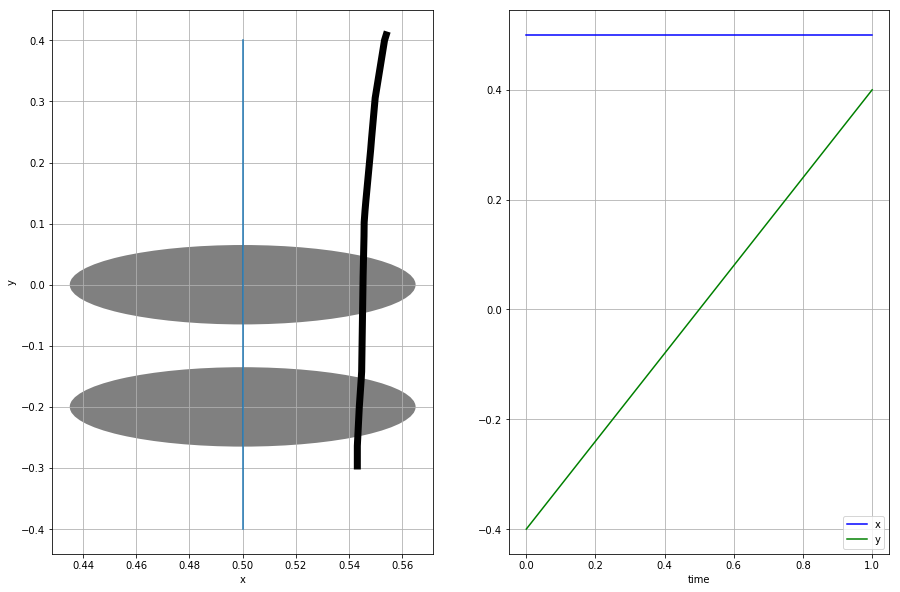

  6434/200000 [..............................] - ETA: 7:28 - loss: 0.0149 - decoder_mlp_loss: 0.0143

KeyboardInterrupt: 

In [19]:
max_training_step = 200000
model.fit_generator(generator(), steps_per_epoch=max_training_step, epochs=1, verbose=1, callbacks=[RCNMP_Callback()])


In [20]:
model.load_weights('exp3_initial.h5')

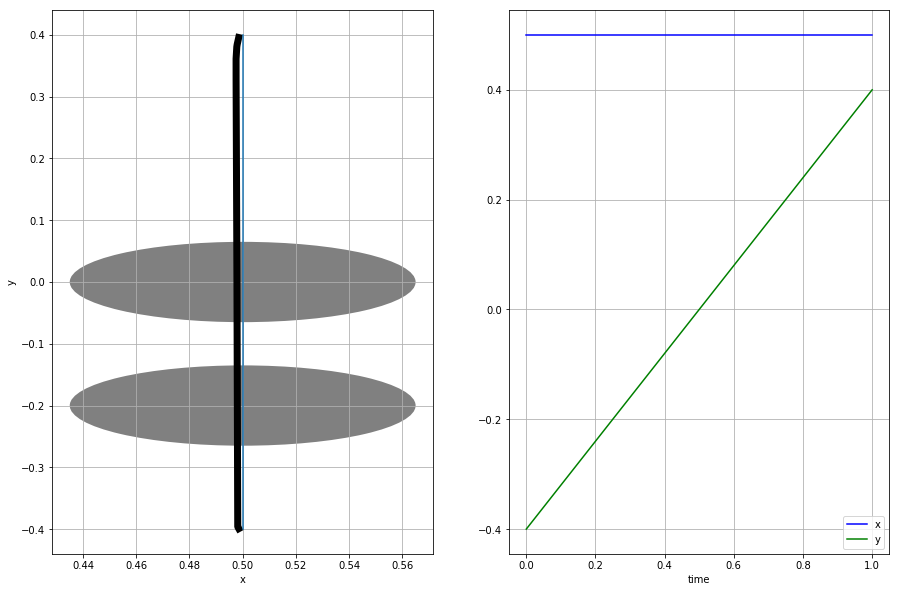

In [21]:
a,b =predict_model(np.concatenate((test_X[0,0],test_Y[0,0])).reshape(1,1,d_x+d_y), test_X[0].reshape(1,time_len,d_x))


In [22]:
def PD(initial=1,final=-5.2879958,fss = np.zeros((time_N)) ):
    pos=np.zeros((time_N))
    vel=np.zeros((time_N))
    err=np.zeros((time_N))
    err_derivative=np.zeros((time_N))
    errsum = 0
    time = np.linspace(0,10,time_N)
    pos[0]=initial
    err[0]=fss[0]-pos[0]
    err_derivative[0] = 0
    for i in range(1,time_N):
        vel[i]= 3*err[i-1] - 1*err_derivative[i-1] 
        pos[i]=(time[i]-time[i-1])*vel[i]+pos[i-1]
        err[i]=(1-times[i]**20)*(fss[i]-pos[i])+(times[i]**20)*3*(final-pos[i])
        err_derivative[i] = err[i]-err[i-1]
    return pos

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

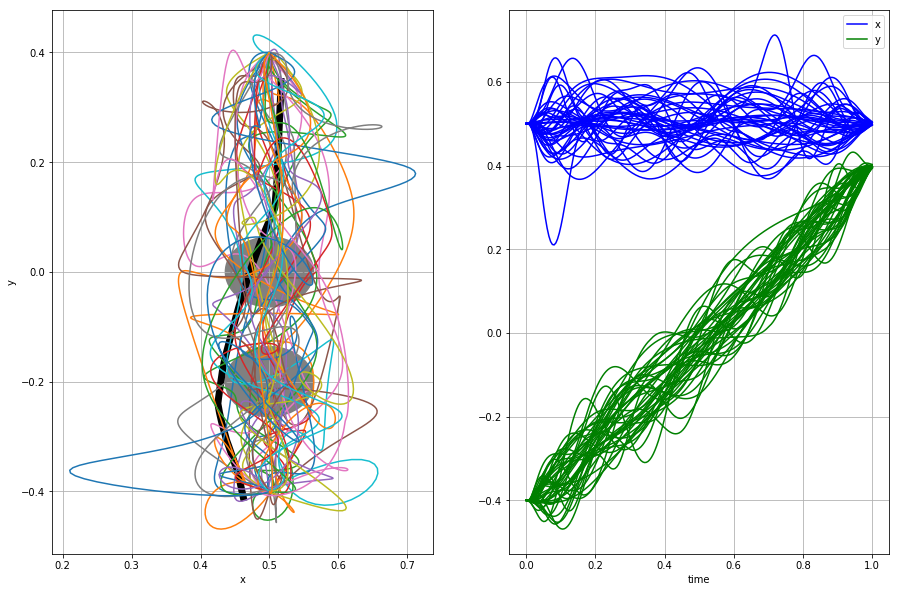

 18258/200000 [=>............................] - ETA: 6:14 - loss: 0.0033 - decoder_mlp_loss: 0.0033

KeyboardInterrupt: 

In [26]:
reward_array = np.zeros((50,50))
for it in range(0,50):
    model.load_weights('exp3_initial.h5')
    initialization()
    gen_size = 20
    cross_size = 20
    global X
    global Y
    global d_N
    global test_X
    model.load_weights('exp3_initial.h5')
    Y_best = np.zeros((1,time_N,2))
    for j in range(time_N):
        test_X[0,j,0]=times[j]

        test_X[0,j,1]=initial_reward
    Y=test_Y
    X=test_X
    
    Y_old = Y
    X_old = X
    
    for i in range(2):
        samples = np.random.normal(0, 0.04, size=20)

        old_indices = np.arange(0,len(samples))
        new_length = 200
        new_indices = np.linspace(0,len(samples)-1,new_length)

        spl = UnivariateSpline(old_indices,samples,k=5,s=0.1)

        task_exploration=PD(0,0,spl(new_indices))
        Y_old[0,:,i] = Y[0,:,i]+ task_exploration
    Y_old[0,:,0] = PD(0.5,0.5,Y_old[0,:,0])
    Y_old[0,:,1] = PD(-0.4,0.4,Y_old[0,:,1])

    Y_best[0] = Y_old[0]
    reward_of_traj = reward_func(Y_old)

    for j in range(time_N):
        X_old[0,j,0]=times[j]
        X_old[0,j,1]=reward_of_traj

    for a in range (100):

        Y_new = np.zeros((gen_size,time_len,2))

        Y_cross = np.zeros((cross_size,time_len,2))

        observation = np.zeros((1,1,d_x+d_y)) 
        observation[0,0,:d_x] = test_X[0,0]
        observation[0,0,d_x:d_x+d_y] = test_Y[0,0]
        target_X = test_X[0].reshape(1,time_len,d_x)

        mean_rep = np.zeros((16))         #mean_representations for best reward
        #var_rep2 = model_z_var2.predict([observation])[0]         #var_representations for best reward
        var_rep2 = (min(a+1,10))* np.ones((16))
        cov_matrix = np.diag(var_rep2)
        temp_reps_list = []
        for i in range(gen_size):
            temp_reps = np.random.multivariate_normal(mean_rep, cov_matrix, 1)

            temp_reps = np.reshape(temp_reps,(1,1,16))         #predicted_traj using reps
            temp_reps_list.append(temp_reps)
            temp_reps = np.repeat(temp_reps,200,axis=1)
            decoder_in = np.concatenate((temp_reps,target_X),axis = 2)
            prediction = Decoder.predict(decoder_in)

            for j in range(2):
                samples = np.random.normal(0, max(0.01,0.1-(0.002*a)), size=20)

                old_indices = np.arange(0,len(samples))
                new_length = 200
                new_indices = np.linspace(0,len(samples)-1,new_length)

                spl = UnivariateSpline(old_indices,samples,k=5,s=0.1)

                task_exploration=PD(0,0,spl(new_indices))
                #if a==0:
                #    Y_new[i,:,j] = test_Y[0,:,j]+ task_exploration
                #else:
                Y_new[i,:,j] = prediction[0,:,j]+ task_exploration

        Y_temp = np.concatenate((Y_old,Y_new),axis=0)
        np.random.shuffle(Y_temp)

        for i in range(int(cross_size/2)):

            r1 = i*2
            r2 = i*2+1

            cut_time = np.random.randint(10, 150)
            
            c_reps1 = temp_reps_list[r1]
            c_reps2 = temp_reps_list[r2]
            aa_reps = np.repeat(c_reps1,cut_time,axis=1)
            bb_reps = np.repeat(c_reps1,200-cut_time,axis=1)
            cc_reps = np.repeat(c_reps2,cut_time,axis=1)
            dd_reps = np.repeat(c_reps2,200-cut_time,axis=1)
            cross_reps1 = np.concatenate((aa_reps,dd_reps), axis = 1)
            cross_reps2 = np.concatenate((bb_reps,cc_reps), axis = 1)
            
            
            decoder_in1 = np.concatenate((cross_reps1,target_X),axis = 2)
            prediction1 = Decoder.predict(decoder_in1)

            for j in range(2):
                samples = np.random.normal(0, max(0.01,0.1-(0.002*a)), size=20)

                old_indices = np.arange(0,len(samples))
                new_length = 200
                new_indices = np.linspace(0,len(samples)-1,new_length)

                spl = UnivariateSpline(old_indices,samples,k=5,s=0.1)

                task_exploration=PD(0,0,spl(new_indices))
                #if a==0:
                #    Y_new[i,:,j] = test_Y[0,:,j]+ task_exploration
                #else:
                Y_cross[r1,:,j] = prediction1[0,:,j]+ task_exploration
            
            
            decoder_in2 = np.concatenate((cross_reps2,target_X),axis = 2)
            prediction2 = Decoder.predict(decoder_in2)

            for j in range(2):
                samples = np.random.normal(0, max(0.01,0.1-(0.002*a)), size=20)

                old_indices = np.arange(0,len(samples))
                new_length = 200
                new_indices = np.linspace(0,len(samples)-1,new_length)

                spl = UnivariateSpline(old_indices,samples,k=5,s=0.1)

                task_exploration=PD(0,0,spl(new_indices))
                #if a==0:
                #    Y_new[i,:,j] = test_Y[0,:,j]+ task_exploration
                #else:
                Y_cross[r2,:,j] = prediction2[0,:,j]+ task_exploration

        Y = np.concatenate((Y_temp,Y_cross),axis=0)
        
        for i in range(len(Y)):
            Y[i,:,0] = PD(0.5,0.5,Y[i,:,0])
            Y[i,:,1] = PD(-0.4,0.4,Y[i,:,1])
        Y = np.concatenate((Y,Y_best),axis=0)
        Y_shuffle = np.concatenate((Y_new,Y_cross),axis=0)
        np.random.shuffle(Y_shuffle)
        X_shuffle = np.zeros((len(Y_shuffle),time_len,2))

        for i in range (len(Y_shuffle)):
            rwrd = reward_func(np.reshape(Y_shuffle[i],(1,time_N,2)))
            for j in range(time_N):
                    X_shuffle[i,j,0]=times[j]
                    X_shuffle[i,j,1]=rwrd      

        X = np.zeros((len(Y),time_len,2))

        r_max = -1000
        d_N = len(Y)
        
        for i in range (len(Y)):

            reward_of_traj = reward_func(np.reshape(Y[i],(1,time_N,2)))
            if reward_of_traj > r_max:
                r_max = reward_of_traj
                Y_best = np.reshape(Y[i],(1,time_N,2))
                
            for j in range(time_N):
                X[i,j,0]=times[j]
                X[i,j,1]=reward_of_traj
        print(np.shape(Y))           
        plot_func(Y)

        for j in range(time_N):
            test_X[0,j,0]=times[j]

            test_X[0,j,1]=r_max

        Y_old = np.concatenate((Y_old,Y_shuffle[-2:]),axis=0)
        X_old = np.concatenate((X_old,X_shuffle[-2:]),axis=0)
        

        if len(Y_old)>10:
            Y_old = Y_old[-10:]
            X_old = X_old[-10:]
        if a<5:
            max_training_step = 200000
        else:
            max_training_step = 50000
        
        print(d_N)
        reward_array[it,a] = r_max
        model.fit_generator(generator(), steps_per_epoch=max_training_step, epochs=1, verbose=1, callbacks=[RCNMP_Callback()])
        if r_max > 3.88:
            observation = np.zeros((1,1,d_x+d_y)) 
            observation[0,0,:d_x] = test_X[0,0]
            observation[0,0,d_x:d_x+d_y] = test_Y[0,0]
            target_X = test_X[0].reshape(1,time_len,d_x)
            Y_result = np.zeros((10,time_N,2))
            for i in range(10):
                prediction = model.predict([observation,target_X])[0][0]
                Y_result[i]=prediction

            plot_func2(Y_result)
            break
            
            
            
        observation = np.zeros((1,1,d_x+d_y)) 
        observation[0,0,:d_x] = test_X[0,0]
        observation[0,0,d_x:d_x+d_y] = test_Y[0,0]
        target_X = test_X[0].reshape(1,time_len,d_x)
        Y_result2 = np.zeros((10,time_N,2))
        for i in range(10):
            prediction = model.predict([observation,target_X])[0][0]

            Y_result2[i]=prediction
        #for i in range(len(Y_result)):
            #Y_result2[i,:,0] = PD(0.5,0.5,Y_result2[i,:,0])
            #Y_result2[i,:,1] = PD(-0.4,0.4,Y_result2[i,:,1])
        plot_func2(Y_result2)
        np.save("deneme{:d}".format(a),Y_result2)